In [5]:
import torch
from torch import nn
from d2l import torch as d2l

#moving_mean,moving_var是全局的均值和方差（整个数据集的），而不是某个小批量的
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    #若当前处于预测模式，则直接对输入的X进行规范化后输出
    if not torch.is_grad_enabled():
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    #若处于训练模式
    else:
        assert len(X.shape) in (2,4)
        #X形状为 (batch_size, num_features)（全连接层）
        if len(X.shape) == 2:
            mean=X.mean(dim=0) #dim=0 只剩一行，mean()和sum()一样，这便是计算特征维上的均值
            var=((X-mean)**2).mean(dim=0)
        #(batch_size, num_channels, height, width)（卷积层）
        #卷积层是用来处理图像的，多少张图像*每张图像通道数*图像高*图像宽
        #batch normalization对卷积层是作用在通道上，因此对除通道外的其他维求平均
        #得到的mean和var为1*n*1*1
        else:
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        #训练模式下，用当前小批量的均值和方差作标准化
        X_hat=(X-mean)/torch.sqrt(var+eps)
        moving_mean=momentum*moving_mean+(1-momentum)*mean
        moving_var=momentum*moving_var+(1-momentum)*var
    Y=gamma*X_hat+beta
    #使用 .data 确保返回的值不包含梯度信息
    return Y,moving_mean.data,moving_var.data

In [2]:
#gamma是要拟合的方差，beta是要拟合的均值
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        #两个可学习的参数，拉伸参数初始化为1，偏移参数初始化为0
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)
    
    def forward(self,X):
        if self.moving_mean.device!=X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        Y,self.moving_mean,self.moving_var=batch_norm(X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
        return Y

In [ ]:
#将batch normalization应用于lenet
#LeNet 是一个经典的卷积神经网络，通常用于处理 28x28 的灰度图像（如 MNIST 数据集）
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*4*4,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNorm(84,num_dims=2),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.264, train acc 0.902, test acc 0.818
12121.5 examples/sec on cuda:0


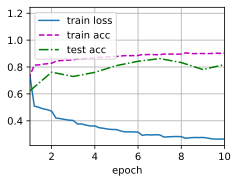

In [6]:
lr,num_epochs,batch_size=1.0,10,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

In [ ]:
#看看在第一个卷积层后面的batch norm层学习到的均值和方差是多少
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([2.5626, 2.7145, 0.6019, 3.6225, 3.7899, 3.1882], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 2.1156,  1.6280, -0.9096,  3.6187, -1.7957,  1.5622], device='cuda:0',
        grad_fn=<ViewBackward0>))